In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, accuracy_score

In [70]:
df_train = pd.DataFrame()
for filename in listdir("dataset\\train\\boxes_transcripts_labels"):
    df_temp = pd.read_csv("dataset\\train\\boxes_transcripts_labels\\" + filename, sep = ",", header = None)
    df_temp.columns = ['start_index', 'end_index', 'x_top_left', 'y_top_left', 'x_bottom_right', 'y_bottom_right','transcript','field']

    df_train = pd.concat([df_train, df_temp], ignore_index = True)

In [61]:
def Feature_Engineering(df):
    df['x_center'] = df[['x_top_left', 'x_bottom_right']].mean(axis=1)
    df['y_center'] = df[['y_top_left', 'y_bottom_right']].mean(axis=1)
    df['index_len'] = df['end_index'] - df['start_index']
    df = df[['start_index', 'end_index', 'x_center', 'y_center', 'index_len', 'field']]

    return df

def X_y_split(df):
    y = df[['field']]
    X = df[['start_index', 'end_index', 'x_center', 'y_center', 'index_len']]
    return X,y

def Hierarchical_Training(df, model1, model2):
    df1 = Feature_Engineering(df)
    df2 = df1.copy()
    df1.loc[df["field"] != "OTHER", "field"] = 'NOT_OTHER'
    rus = RandomUnderSampler(random_state=0, sampling_strategy=0.5)
    X1,y1 = X_y_split(df1)
    resampled_X1, resampled_y1 = rus.fit_resample(X1,y1)

    model1 = model1.fit(resampled_X1, resampled_y1.values.ravel())
    df2 = df2.loc[df2['field'] != 'OTHER']
    X2,y2 = X_y_split(df2)

    model2 = model2.fit(X2, y2.values.ravel())

    return model1, model2


def Testing(df, model1, model2):
    df1 = Feature_Engineering(df)
    X_test, y_test = X_y_split(df1)

    main_pred = []
    y_test1 = y_test.copy()
    y_test1.loc[y_test1["field"] != "OTHER", "field"] = 'NOT_OTHER'

    y_pred1 = model1.predict(X_test)
    y_pred2 = model2.predict(X_test)


    cm_other = confusion_matrix(y_test1, y_pred1)
    for i in range(len(y_pred1)):
        if y_pred1[i] != 'OTHER': main_pred.append(y_pred2[i])
        else: main_pred.append(y_pred1[i])
    
    cm_main = confusion_matrix(y_test, main_pred)

    return cm_main, cm_other

def Testing_with_pred(df, model1, model2):
    df['x_center'] = df[['x_top_left', 'x_bottom_right']].mean(axis=1)
    df['y_center'] = df[['y_top_left', 'y_bottom_right']].mean(axis=1)
    df['index_len'] = df['end_index'] - df['start_index']
    df = df[['start_index', 'end_index', 'x_center', 'y_center', 'index_len']]

    main_pred = []

    y_pred1 = model1.predict(df)
    y_pred2 = model2.predict(df)

    for i in range(len(y_pred1)):
        if y_pred1[i] != 'OTHER': main_pred.append(y_pred2[i])
        else: main_pred.append(y_pred1[i])
    
    return main_pred

In [62]:
# Initialize models
n = 200
model1 = RandomForestClassifier(n_estimators=n, verbose=1)
model2 = RandomForestClassifier(n_estimators=n, verbose=1)
model1, model2 = Hierarchical_Training(df_train, model1, model2)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   16.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.1s


In [64]:
df_test = pd.read_csv("dataset\\val_w_ann\\boxes_transcripts_labels\\0b55f878-9dc7-478b-9bba-342056684452_document-1_page-1.tsv", sep = ',', header = None)
df_test.columns = ['start_index', 'end_index', 'x_top_left', 'y_top_left', 'x_bottom_right', 'y_bottom_right','transcript', 'field']

In [65]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


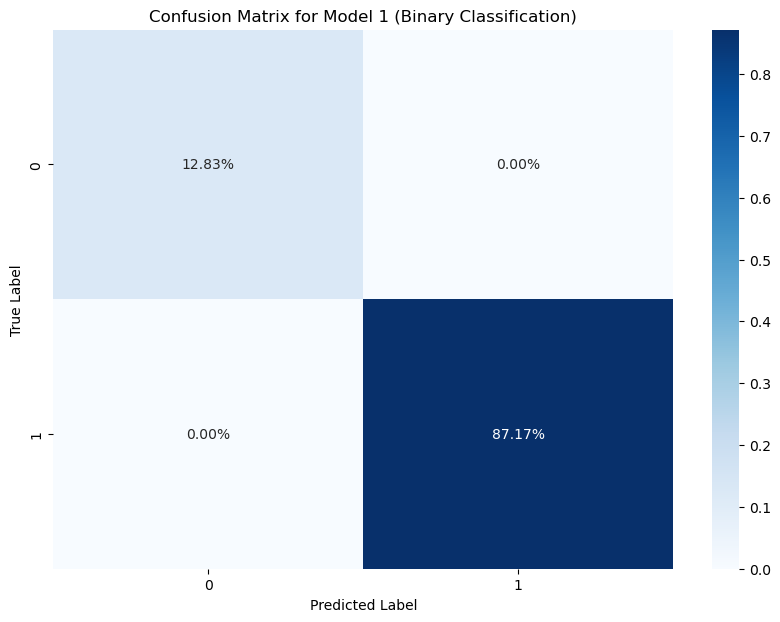

Accuracy for entire data: 100.00%


In [66]:
cm_main, cm_other = Testing(df_test, model1, model2)

# Normalize and plot confusion matrix for model1 (binary classification)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_other / np.sum(cm_other), annot=True, fmt='.2%', cmap='Blues', cbar=True)
plt.title('Confusion Matrix for Model 1 (Binary Classification)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Accuracy calculation for the entire data
accuracy = np.trace(cm_main) / float(np.sum(cm_main))
print('Accuracy for entire data: {:.2%}'.format(accuracy))

In [67]:
df = pd.DataFrame()

for filename in listdir("dataset\\val\\boxes_transcripts"):
    df = pd.read_csv("dataset\\val\\boxes_transcripts\\" + filename, sep = ",", header = None)
    df.columns = ['start_index', 'end_index', 'x_top_left', 'y_top_left', 'x_bottom_right', 'y_bottom_right','transcript']

    df_test = df.copy()

    y_pred = Testing_with_pred(df_test, model1, model2)
    ydf = pd.DataFrame(y_pred, columns=['field'])
    out = pd.concat([df, ydf], axis=1)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do